In [1]:
import numpy as np
from scipy.linalg import eigh, eig
from scipy.sparse import diags
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter  # Import PillowWriter
import time
from numba import jit

In [2]:
@jit(nopython=True)
def create_reflective_laplacian(N, shape):
    if shape == 'square':
        n, m = N, N
    elif shape == 'rectangle':
        n, m = N, N*2
    
    tot_shape = n*m
    M = np.zeros((tot_shape, tot_shape))  # Initialize matrix with zeros

    for i in range(tot_shape):
        # Default value for cells
        M[i, i] = -4
        
        # Calculate row and column in the grid
        row, col = divmod(i, m)

        # Set connections for adjacent cells, considering the grid layout
        if col != 0:  # Not on the left edge
            M[i, i - 1] = 1  # Left neighbor
        if col != (m - 1):  # Not on the right edge
            M[i, i + 1] = 1  # Right neighbor
        if row != 0:  # Not on the top edge
            M[i, i - m] = 1  # Top neighbor
        if row != (n - 1):  # Not on the bottom edge
            M[i, i + m] = 1  # Bottom neighbor

    return M

# Example usage
N = 3
shapes = ['square', 'rectangle']
for shape in shapes:
    M = create_reflective_laplacian(N, shape)
    print(f'{shape} grid:')
    print(M)

square grid:
[[-4.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  1. -4.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0. -4.  1.  0.  1.  0.  0.]
 [ 0.  1.  0.  1. -4.  1.  0.  1.  0.]
 [ 0.  0.  1.  0.  1. -4.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0. -4.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  1. -4.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  1. -4.]]
rectangle grid:
[[-4.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -4.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -4.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -4.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -4.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0. -4.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  1. -4.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  

In [3]:
import numpy as np
from scipy.linalg import eigh

def create_circular_laplacian(N, radius):
    # Total points
    n, m = N, N
    # Center of the circle, adjusted for the rectangular grid
    center = np.array([n / 2 - 0.5, m / 2 - 0.5])
    # Initialize the matrix
    M = np.zeros((N**2, N**2))

    # Identify points inside the circle
    inside_circle = []
    for i in range(n):
        for j in range(m):
            if (np.array([i, j]) - center).dot(np.array([i, j]) - center) <= radius**2:
                inside_circle.append(i * m + j)

    # Now build the Laplacian only for these points
    for idx in inside_circle:
        x, y = divmod(idx, m)
        M[idx, idx] = -4
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            new_idx = nx * m + ny
            if 0 <= nx < n and 0 <= ny < m and new_idx in inside_circle:
                M[idx, new_idx] = 1

    # Filter out the unused rows and columns
    M = M[np.ix_(inside_circle, inside_circle)]

    return M

# Example usage
N = 50
radius = 20  # Adjust radius as needed
L_circle_corrected = create_circular_laplacian(N, radius)

# Check if the matrix is square
if L_circle_corrected.shape[0] == L_circle_corrected.shape[1]:
    print("The matrix is square.")
    try:
        vals_circle, vecs_circle = eigh(L_circle_corrected)
        # Continue with your analysis or plotting
    except ValueError as e:
        print("Error in eigenvalue computation:", e)
else:
    print("The matrix is not square, check the Laplacian construction.")


The matrix is square.


In [4]:
L = 1
N = 50

# Square grid (already done)
shape = 'square'
L_square = create_reflective_laplacian(N, shape)

# Rectangle grid
shape = 'rectangle'
L_rect = create_reflective_laplacian(N, shape)

# Circular grid
radius = 2  # Make sure L and n are defined
L_circle = create_circular_laplacian(N)

TypeError: create_circular_laplacian() missing 1 required positional argument: 'radius'

In [ ]:
def solve_eigenproblem(L_square, L, N):
    # Solve the eigenvalue problem
    eigenvalues, eigenvectors = eigh(L_square)

    # Convert eigenvalues to real numbers
    eigenvalues = np.real(eigenvalues)
    eigenvalues = eigenvalues * (1/(L/N)**2)

    # Create the dictionary mapping eigenvalues to eigenvectors
    eigen_dict = {}
    for i, val in enumerate(eigenvalues):
        vec = eigenvectors[:, i]
        # Convert complex eigenvectors to real and make them lists for easy representation
        vec_list = np.real(np.abs(vec)).tolist()
        # Add to dictionary
        eigen_dict[val] = vec_list

    return eigen_dict

In [ ]:
def embed_eigenvector_in_grid(eigenvector, N, inside_circle):
    # Create an empty array for the full grid
    full_grid = np.zeros(N * N)

    # Place the components of the eigenvector into the full grid at the appropriate locations
    for index, value in zip(inside_circle, eigenvector):
        full_grid[index] = value

    # Reshape the full grid back into a 2D array
    full_grid = full_grid.reshape((N, N))

    return full_grid


In [ ]:
def plot_circular_eigenvectors(vals_circle, vecs_circle, N, radius, num_eigenvectors=5):
    n, m = N, N
    # Calculate the positions inside the circle to properly embed eigenvectors later
    center = np.array([n / 2 - 0.5, m / 2 - 0.5])
    inside_circle = [i * m + j for i in range(n) for j in range(m) 
                     if np.linalg.norm(np.array([i, j]) - center) <= radius]

    # Sort eigenvalues and pick the indices of the closest to zero
    indices_closest = np.argsort(np.abs(vals_circle))[:num_eigenvectors]

    # Set up the plot
    # Set up the plot
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()  # Flatten the axes array to iterate over it

    # Plot the specified number of closest eigenvectors
    for i, idx in enumerate(indices_closest):
        # Embed the eigenvector back into the full grid
        full_grid = embed_eigenvector_in_grid(np.abs(vecs_circle[:, idx]), N, inside_circle)
        
        # Plot the heatmap
        c = axes[i].imshow(full_grid, cmap='viridis', extent=[0, m, 0, n], origin='lower')
        axes[i].set_title(f'Eigenvalue: {vals_circle[idx]:.2f}')
        axes[i].axis('on')
    
    cbar_ax = fig.add_axes([1, 0.04, 0.02, 0.915])  # [left, bottom, width, height]
    cbar = fig.colorbar(c, cax=cbar_ax)
    cbar.set_label('Frequency', fontsize=14)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_eigenvectors(eigen_dict, shape=None, N=None, radius = None, num_eigenvectors=10, target_eigenvalue=0):
    if shape == 'circle':
        eigenvalues = eigen_dict[0]
        eigenvectors = eigen_dict[1]
        plot_circular_eigenvectors(eigenvalues, eigenvectors, N, radius, num_eigenvectors)
    else:
        if N is None:
            nrows, ncols = None, None
            col = [1, 0.04, 0.02, 0.915]
        else:
            nrows, ncols = N, N*2
            col = [1, 0.15, 0.02, 0.65]
        
        # Sort eigenvalues based on closeness to the target_eigenvalue, select the closest num_eigenvectors
        sorted_eigenvals = sorted(eigen_dict.keys(), key=lambda x: abs(x - target_eigenvalue))
        closest_eigenvals = sorted_eigenvals[:num_eigenvectors]

       # Set up the plot
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.flatten()  # Flatten the axes array to iterate over it

        # Plot each of the closest eigenvectors as a heatmap
        for ax, eigenvalue in zip(axes, closest_eigenvals):
            eigenvector = eigen_dict[eigenvalue]
            if nrows is None and ncols is None:
                # Fallback to square shape if dimensions are not specified
                side_length = int(np.sqrt(len(eigenvector)))
                matrix = np.reshape(eigenvector, (side_length, side_length))
            else:
                # Reshape eigenvector to a rectangle or square array
                matrix = np.reshape(eigenvector, (nrows, ncols))
            
            # Plot the heatmap
            c = ax.imshow(matrix, cmap='viridis', aspect='auto')
            # fig.colorbar(c, ax=ax)
            ax.set_aspect('equal')
            ax.set_title(f'Eigenvalue: {np.round(eigenvalue, 2)}')  # Using scientific notation for clarity

        cbar_ax = fig.add_axes(col)  # [left, bottom, width, height]
        cbar = fig.colorbar(c, cax=cbar_ax)
        cbar.set_label('Frequency', fontsize=14)

        plt.tight_layout()
        plt.show()

2364


C:\Users\sacha\AppData\Local\Temp\ipykernel_8452\517751562.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


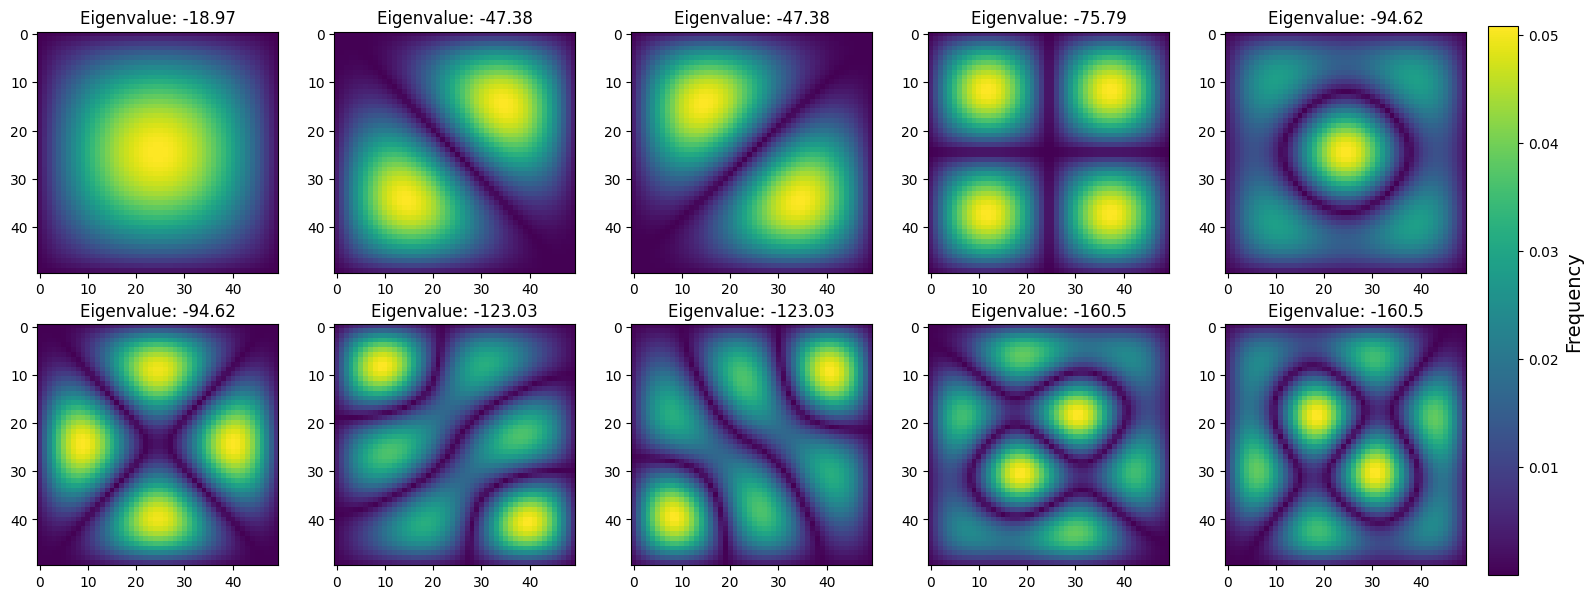

In [ ]:
eigen_dict = solve_eigenproblem(L_square, L, N)
print(len(eigen_dict))
plot_eigenvectors(eigen_dict)

ValueError: cannot reshape array of size 5000 into shape (20,40)

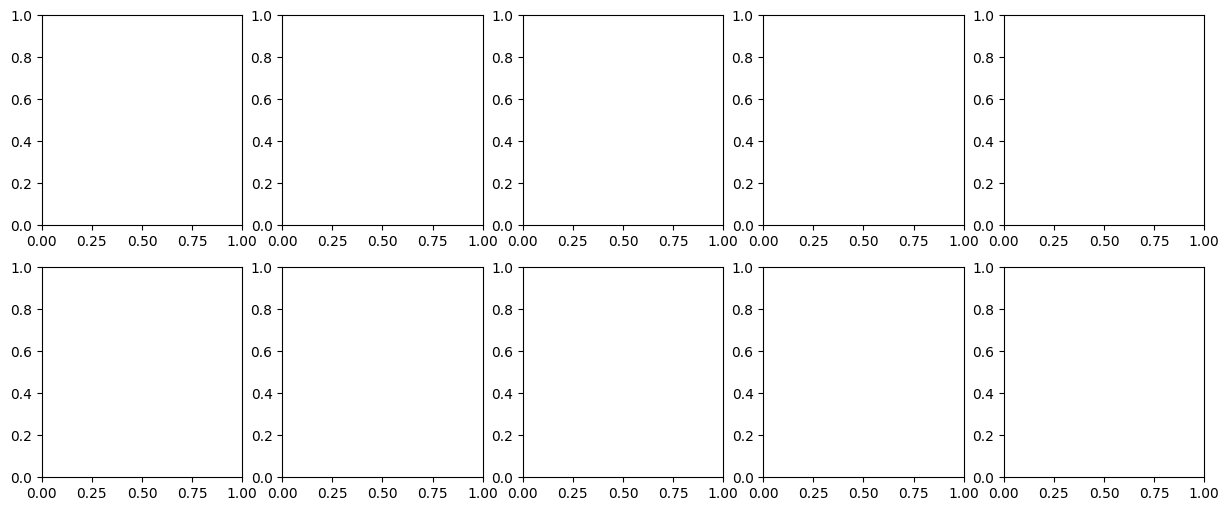

In [ ]:
eigen_dict = solve_eigenproblem(L_rect, L, N)
plot_eigenvectors(eigen_dict, 'rect', N)

C:\Users\sacha\AppData\Local\Temp\ipykernel_11660\1810196613.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


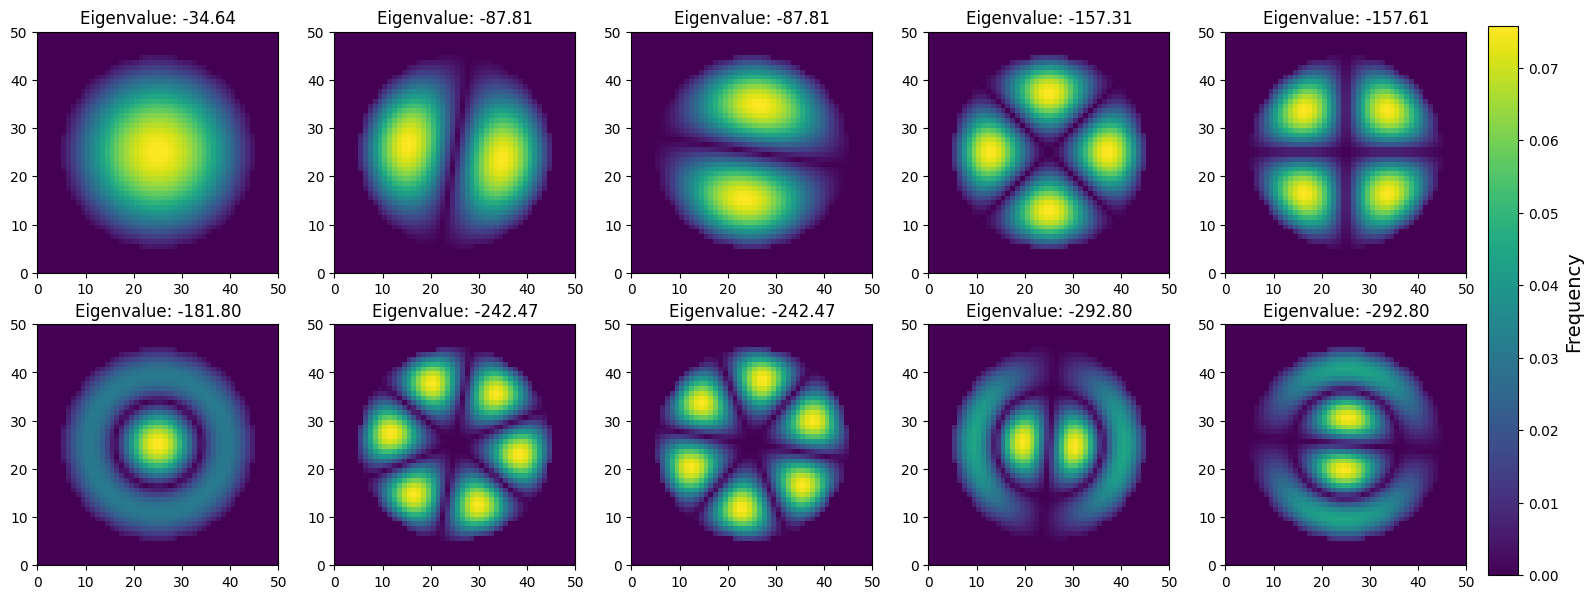

In [40]:
# Usage example
L = 1
N = 50
L_circle_corrected = create_circular_laplacian(N, radius)
vals_circle, vecs_circle = eigh(L_circle_corrected)
dict_circle = vals_circle * (1/(L/N)**2), vecs_circle

plot_eigenvectors(dict_circle, 'circle', N, 20)  # Adjust num_eigenvectors if needed


Grotere eigenwaardes voor circel. IDK wat ik er over wil zeggen


In the provided code, eigh() from scipy.linalg was used to solve the eigenvalue problem for the Laplacian matrix representing the reflective boundary conditions. The choice of eigh() over other options like eig() or eigs() was made because eigh() is specifically designed to efficiently solve Hermitian eigenvalue problems for symmetric matrices.

Since the Laplacian matrix representing the reflective boundary conditions is symmetric due to the nature of the problem, using eigh() is appropriate and efficient. This function is optimized for symmetric matrices, leading to faster computation times compared to other methods when dealing with such matrices. Therefore, eigh() was selected for its efficiency and suitability for the given problem.

In [59]:
# Example usage
N = 50
Lap = create_reflective_laplacian(N, 'square')

# Solve the eigenvalue problem using scipy.linalg.eig()
start_time = time.time()
eigenvalues_eig, eigenvectors_eig = eig(Lap)
end_time = time.time()
eig_time = end_time - start_time

# Solve the eigenvalue problem using scipy.linalg.eigh()
start_time = time.time()
eigenvalues_eigh, eigenvectors_eigh = eigh(Lap)
end_time = time.time()
eigh_time = end_time - start_time


# Solve the eigenvalue problem using scipy.sparse.linalg.eigs() for sparse matrices
start_time = time.time()
eigenvalues_eigs, eigenvectors_eigs = eigs(Lap)
end_time = time.time()
eigs_time = end_time - start_time

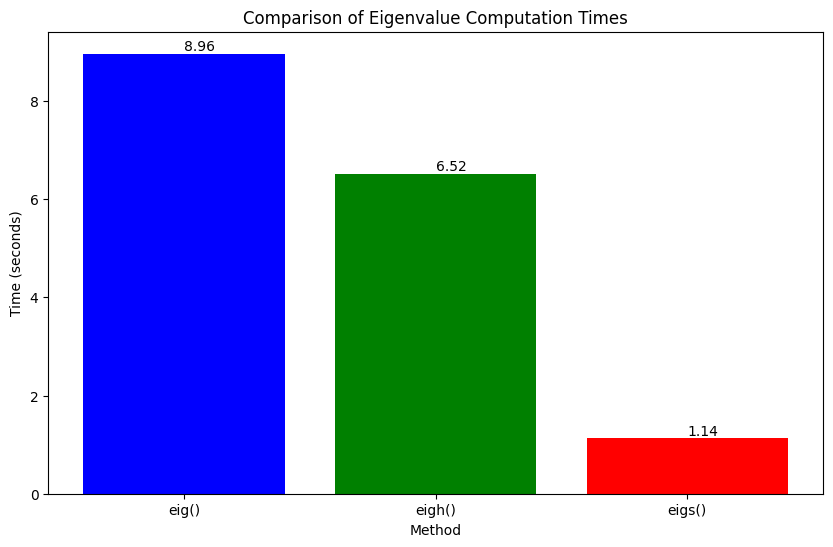

In [60]:
# Computation times from your results
method_names = ['eig()', 'eigh()', 'eigs()']
times = [eig_time, eigh_time, eigs_time]

# Create a bar chart
plt.figure(figsize=[10,6])
bars = plt.bar(method_names, times, color=['blue', 'green', 'red'])

# Add the exact computation time above each bar for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom')  # Adjust the format as needed

# Set chart title and labels
plt.title('Comparison of Eigenvalue Computation Times')
plt.ylabel('Time (seconds)')
plt.xlabel('Method')

# Show the plot
plt.show()


In [ ]:
# Function to solve and return eigenvalues
def solve_eigenvals(Laplace_matrix, dx):
    eigenvalues, _ = eigh(Laplace_matrix)  # Only need eigenvalues, not eigenvectors\
    eigenvalues = eigenvalues * (1/(dx)**2)
    return np.sqrt(np.abs(eigenvalues)) # Return the square root of eigenvalues for frequencies

# Define sizes and shapes for the analysis
N= 50
L_list = []
for l in range(1, 5):
    L_list.append(l)  # From 5x5 to 25x25 with steps of 5
shapes = ['square', 'rectangle', 'circle']
radius = 20  # Fixed radius for circular shape
results = {shape: [] for shape in shapes}

# Calculate eigenfrequencies for each shape and size
for L in L_list:
    for shape in shapes:
        if shape == 'circle':
            Laplace_matrix = create_circular_laplacian(N, radius=radius)
        else:
            Laplace_matrix = create_reflective_laplacian(N, shape)  # Double the size for rectangle
        
        dx = L/N
        frec = solve_eigenvals(Laplace_matrix, dx)
        frec = sorted(frec)
        results[shape].append(frec)

# print(results[shape])
# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for ax, shape in zip(axes, shapes):
    for L, freqs in zip(L_list, results[shape]):
        ax.plt(freqs, label=f'L={L}')
    ax.set_title(f'{shape.capitalize()} shape')
    ax.set_xlabel('Vector length')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()

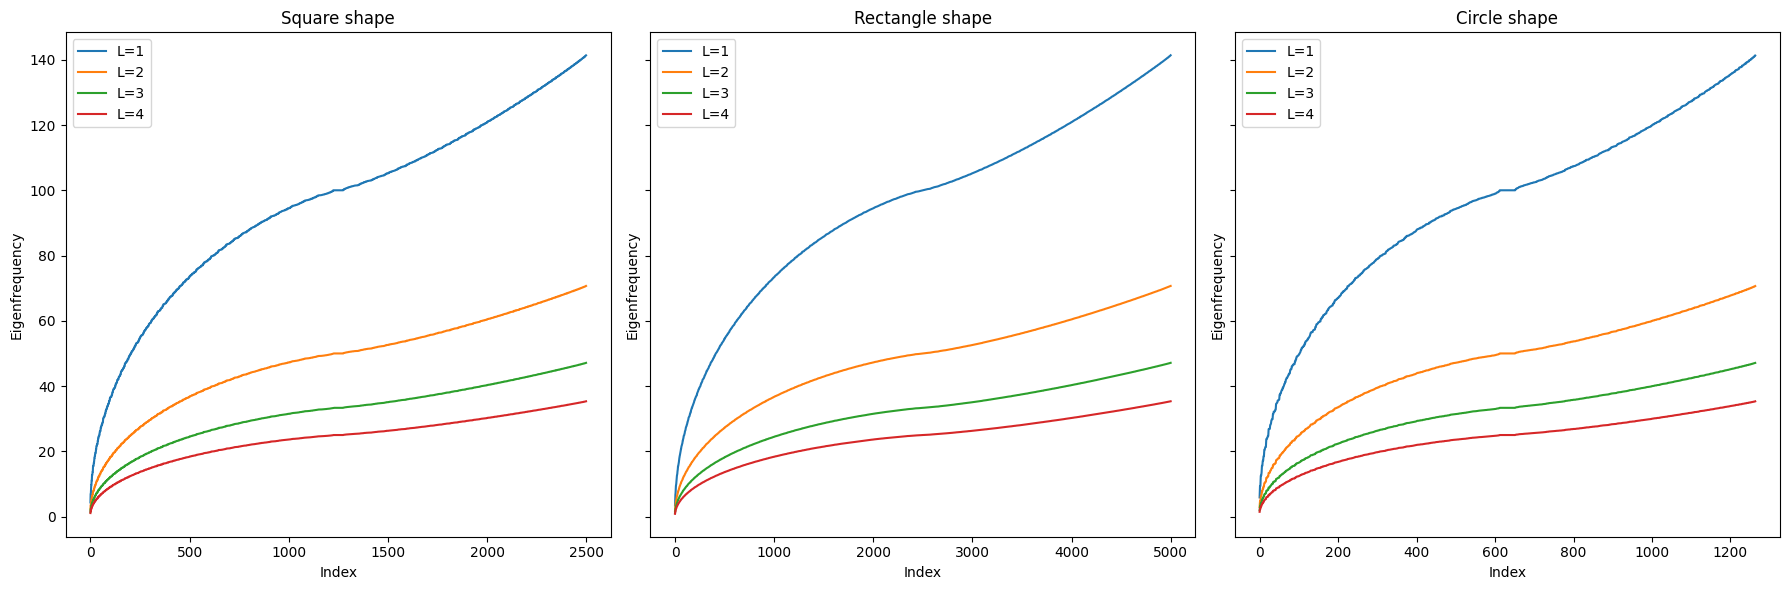

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for ax, shape in zip(axes, shapes):
    for L, freqs in zip(L_list, results[shape]):
        ax.plot(freqs, label=f'L={L}')
    ax.set_title(f'{shape.capitalize()} shape')
    ax.set_xlabel('Index')
    ax.set_ylabel('Eigenfrequency')
    ax.legend()

plt.tight_layout()
plt.show()

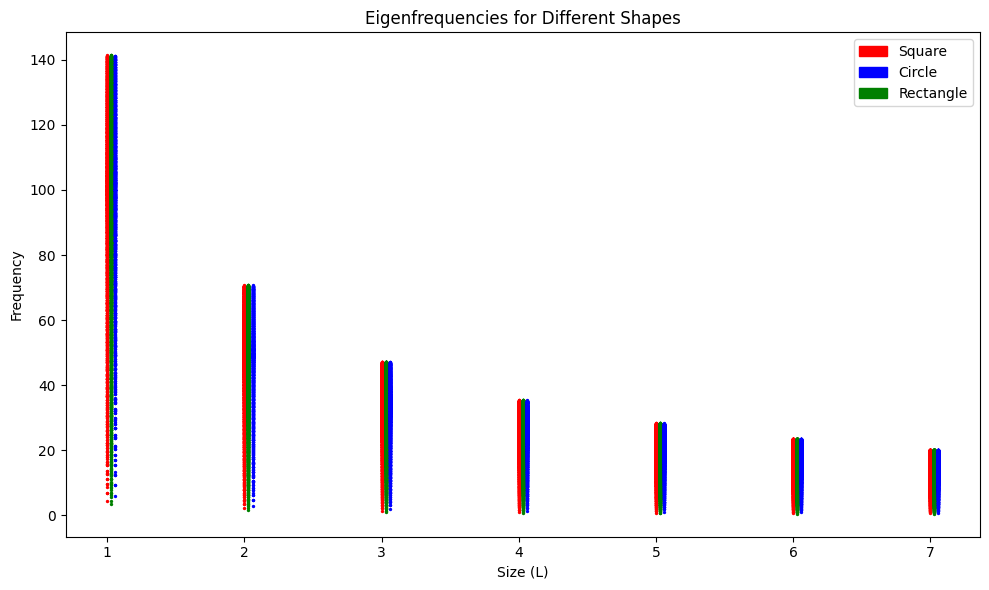

In [7]:
from matplotlib.patches import Patch

# Function to solve and return eigenvalues
def solve_eigenvals(Laplace_matrix, dx):
    eigenvalues, _ = eigh(Laplace_matrix)  # Only need eigenvalues, not eigenvectors\
    eigenvalues = eigenvalues * (1/(dx)**2)
    return np.sqrt(np.abs(eigenvalues)) # Return the square root of eigenvalues for frequencies

# Define sizes and shapes for the analysis
N= 50
L_list = []
for l in range(1, 8):
    L_list.append(l)  # From 5x5 to 25x25 with steps of 5
shapes = ['square', 'rectangle', 'circle']
radius = 20  # Fixed radius for circular shape
results = {shape: [] for shape in shapes}

# Calculate eigenfrequencies for each shape and size
for L in L_list:
    for shape in shapes:
        if shape == 'circle':
            Laplace_matrix = create_circular_laplacian(N, radius=radius)
        else:
            Laplace_matrix = create_reflective_laplacian(N, shape)  # Double the size for rectangle
        
        dx = L/N
        frec = solve_eigenvals(Laplace_matrix, dx)
        frec = sorted(frec)
        results[shape].append(frec)
        
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for different shapes
colors = {'square': 'r', 'rectangle': 'g', 'circle': 'b'}

# Define an offset for each shape's scatter plot
offset = 0.03

# Plot scatter points for each shape
for idx, shape in enumerate(results.keys()):
    for L, frequencies in zip(L_list, results[shape]):
        ax.scatter([L + offset * idx] * len(frequencies), frequencies, color=colors[shape], s=2, label=shape.capitalize())

ax.set_xlabel('Size (L)')
ax.set_ylabel('Eigenfrequency')
# legend = ['Square', 'Rectangle', 'Circle']

handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))

# Create legend with unique labels
legend_handles = [Patch(color=colors[label.lower()], label=label.capitalize()) for label in unique_labels]
ax.legend(handles=legend_handles)


# ax.legend()

plt.tight_layout()
plt.show()



[27.99637815 27.57080523 27.57080523 27.13855953 26.88625562 26.88625562
 26.44282234 26.44282234 25.98040795 25.98040795 25.72827809 25.52124035
 25.52124035 24.90705849 24.90705849 24.78013619 24.78013619 24.42772348
 24.42772348 23.79424311 23.73679901 23.73679901 23.65238074 23.65238074
 23.2333325  23.2333325  22.61738204 22.61738204 22.55694111 22.55694111
 22.41671651 22.41671651 22.02652274 22.02652274 21.46919765 21.46919765
 21.37582596 21.32182063 21.32182063 21.1633916  21.1633916  20.91120656
 20.91120656 20.58270847 20.58270847 20.         20.         20.
 20.         20.         20.         20.         20.         20.
 20.         19.3997967  19.3997967  19.04524718 19.04524718 18.76461712
 18.76461712 18.58440112 18.58440112 18.52225863 18.41394993 18.41394993
 17.7435142  17.7435142  17.24792222 17.24792222 17.06412634 17.06412634
 16.98393446 16.98393446 16.13109609 16.13109609 15.51015427 15.51015427
 15.3806493  15.3806493  15.29163153 14.25785137 14.25785137 13.636

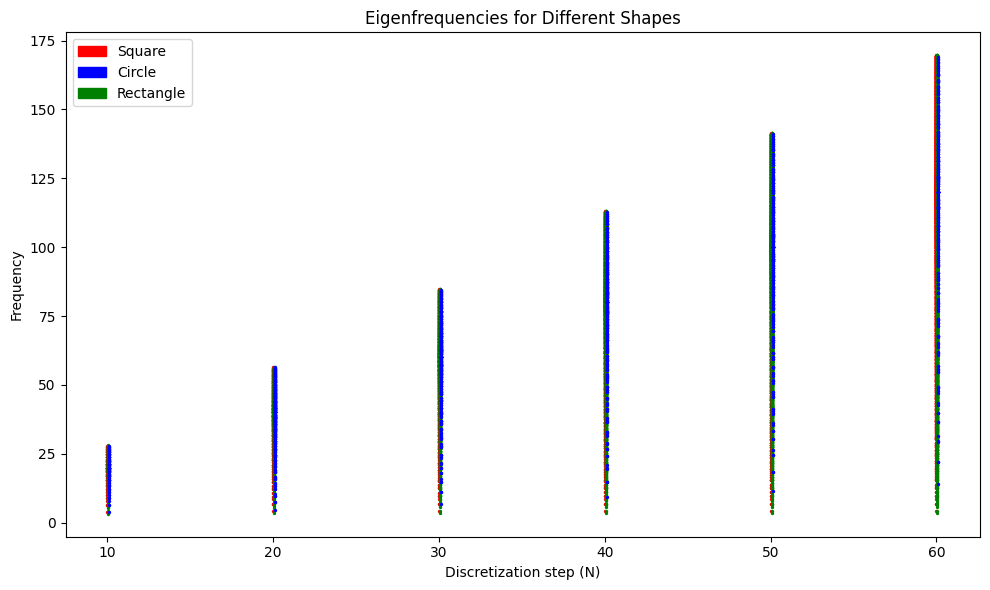

In [9]:
# Function to solve and return eigenvalues
def solve_eigenvals(Laplace_matrix, dx):
    eigenvalues, _ = eigh(Laplace_matrix)  # Only need eigenvalues, not eigenvectors\
    eigenvalues = eigenvalues * (1/(dx)**2)
    return np.sqrt(np.abs(eigenvalues)) # Return the square root of eigenvalues for frequencies

# Define sizes and shapes for the analysis
L= 1
N_list = []
for n in range(10, 70, 10):
    N_list.append(n)  # From 5x5 to 25x25 with steps of 5
shapes = ['square', 'rectangle', 'circle']
radius = 10  # Fixed radius for circular shape
results = {shape: [] for shape in shapes}

# Calculate eigenfrequencies for each shape and size
for N in N_list:
    for shape in shapes:
        if shape == 'circle':
            Laplace_matrix = create_circular_laplacian(N, radius=radius)
        else:
            Laplace_matrix = create_reflective_laplacian(N, shape)  # Double the size for rectangle
        
        dx = L/N
        frec = solve_eigenvals(Laplace_matrix, dx)
        print(frec)
        frec = sorted(frec)
        results[shape].append(frec)

      
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for different shapes
colors = {'square': 'r', 'rectangle': 'g', 'circle': 'b'}

# Define an offset for each shape's scatter plot
offset = 0.1

# Plot scatter points for each shape
for idx, shape in enumerate(results.keys()):
    for N, freqs in zip(N_list, results[shape]):
        ax.scatter([N + offset * idx] * len(freqs), freqs, color=colors[shape], s=2, label=shape.capitalize())
ax.set_xlabel('Discretization step (N)')
ax.set_ylabel('Frequency')

handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))

# Create legend with unique labels
legend_handles = [Patch(color=colors[label.lower()], label=label.capitalize()) for label in unique_labels]
ax.legend(handles=legend_handles)


plt.tight_layout()
plt.show()

c:\Users\koenw\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


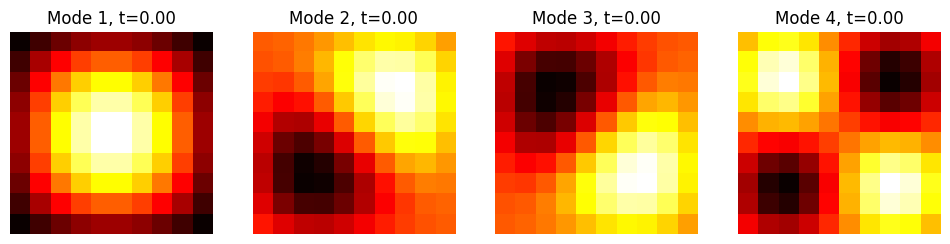

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Assuming this is the create_reflective_laplacian function you provided earlier
def create_reflective_laplacian(n, m):
    N = n * m
    M = np.zeros((N, N))
    for i in range(N):
        M[i, i] = -4
        row, col = divmod(i, m)
        if col != 0:
            M[i, i - 1] = 1
        if col != (m - 1):
            M[i, i + 1] = 1
        if row != 0:
            M[i, i - m] = 1
        if row != (n - 1):
            M[i, i + m] = 1
    return M

# Parameters
n, m = 10, 10  # Grid dimensions
c = 1         # Coefficient in your time-dependent part
t_max = 10    # Maximum time
dt = 0.1      # Time step
num_modes = 4 # Number of eigenmodes to display
A, B = 1, 0   # Example initial conditions, replace with actual values if available

# Create Laplacian matrix and find its eigenvalues and eigenvectors
L = create_reflective_laplacian(n, m)
eigenvalues, eigenvectors = np.linalg.eigh(-L)  # Use negative Laplacian

# Setup for animation
fig, axes = plt.subplots(1, num_modes, figsize=(12, 3))

def animate(t):
    for i in range(num_modes):
        # Time-dependent part based on your provided formula
        time_part = A * np.cos(c * np.sqrt(eigenvalues[i]) * t) + B * np.sin(c * np.sqrt(eigenvalues[i]) * t)
        
        # Update each subplot
        axes[i].clear()
        axes[i].imshow(eigenvectors[:, i].reshape(n, m) * time_part, cmap='hot', interpolation='nearest')
        axes[i].set_title(f'Mode {i+1}, t={t:.2f}')
        axes[i].axis('off')

# Create and display animation
ani = animation.FuncAnimation(fig, animate, frames=np.arange(0, t_max, dt), interval=50)

# Save the animation as a GIF using Pillow
writer = PillowWriter(fps=20)  # Adjust fps as needed for smoother animation
ani.save('time_dependent_modes.gif', writer=writer)


# 2

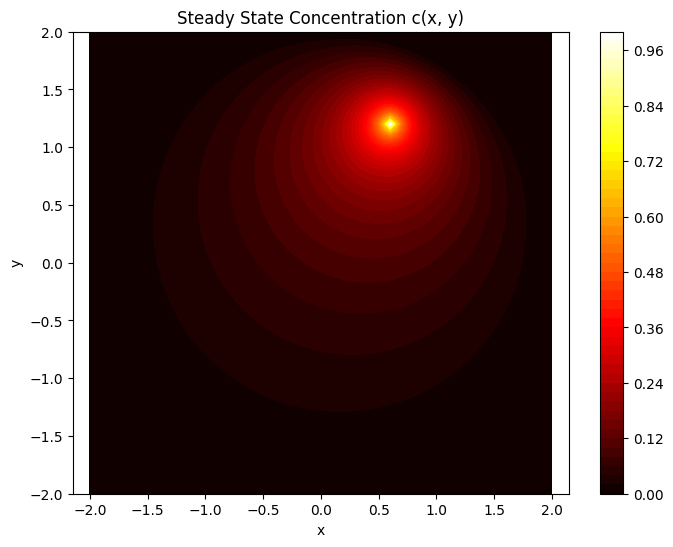

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

# Parameters
radius = 2
source_point = (0.6, 1.2)
source_value = 1
grid_size = 0.05  # Distance between grid points
domain_points = int(2 * radius / grid_size) + 1  # Number of points in each dimension

# Function to check if a point is inside the circular domain
def inside_circle(x, y, center, radius):
    return (x - center[0])**2 + (y - center[1])**2 < radius**2

# Generate grid points
x = np.linspace(-radius, radius, domain_points)
y = np.linspace(-radius, radius, domain_points)
X, Y = np.meshgrid(x, y)

# Initialize matrices and vectors
M_data = []
M_row_indices = []
M_col_indices = []
b = np.zeros(domain_points**2)

# Populate the matrices and vectors
for i in range(domain_points):
    for j in range(domain_points):
        idx = i * domain_points + j  # Flatten the 2D grid index to a 1D index
        if inside_circle(X[i, j], Y[i, j], (0, 0), radius):
            if np.isclose(X[i, j], source_point[0]) and np.isclose(Y[i, j], source_point[1]):
                # Source point
                M_data.append(1)
                M_row_indices.append(idx)
                M_col_indices.append(idx)
                b[idx] = source_value
            else:
                # Internal point - Apply the finite difference method
                M_data.extend([1, -1/4, -1/4, -1/4, -1/4])
                M_row_indices.extend([idx, idx, idx, idx, idx])
                M_col_indices.extend([idx, idx - 1, idx + 1, idx - domain_points, idx + domain_points])
                b[idx] = 0
        else:
            # Boundary point
            M_data.append(1)
            M_row_indices.append(idx)
            M_col_indices.append(idx)
            b[idx] = 0

# Create the sparse matrix M
M = coo_matrix((M_data, (M_row_indices, M_col_indices)), shape=(domain_points**2, domain_points**2))

# Solve Mc = b
c = spsolve(M.tocsr(), b)

# Reshape c back into a 2D array
c = c.reshape((domain_points, domain_points))

# Plotting
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, c, levels=50, cmap='hot')
plt.colorbar(contour)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Steady State Concentration c(x, y)')
plt.axis('equal')
plt.show()


The matrix M and the vector b are constructed to represent the discretized version of the Laplace equation (∇²c = 0) for the diffusion problem within a circular domain, under certain boundary conditions. Here's a detailed breakdown of how this is done:

### 1. Grid Discretization:
We start by creating a grid of points that covers the circular domain with a certain grid size (spacing between points). This grid is used to approximate the continuous domain with discrete points where the solution will be computed.

### 2. Constructing the Matrix M:
The matrix M represents the discretized Laplacian operator (∇²) used in the diffusion equation, applied to each grid point. For interior points (not on the boundary), we use the five-point stencil method, which is a finite difference method for approximating the Laplacian. The idea here is to relate the value of the function at a point to the values at its immediate neighbors to approximate second derivatives.

For a grid point (i, j), this approximation is given by:
\[ \nabla^2 c \approx \frac{c_{i+1,j} + c_{i-1,j} + c_{i,j+1} + c_{i,j-1} - 4c_{i,j}}{(\text{grid size})^2} \]

In the matrix M, this corresponds to setting the central coefficient for point (i, j) to 1 (accounting for the -4 in the numerator when normalized by grid size squared) and the coefficients for the immediate neighbors to -1/4. For grid points near the edge but not on the boundary, if a neighbor falls outside the circle, that neighbor is ignored (effectively setting that term to zero).

### 3. Constructing the Vector b:
The vector b represents the boundary conditions and the source terms of the problem. For most grid points, this will be zero, reflecting the fact that there's no source there and the standard Laplace equation is ∇²c = 0. However, for points at the boundary of the domain, we set the corresponding value in b to 0, reflecting the Dirichlet boundary condition (c = 0 at the boundary).

For the source point (in this case at (0.6, 1.2)), we find the corresponding grid point and set its value in the vector b to the source concentration (1 in this case). This effectively enforces the condition that the concentration at this point remains fixed at 1.

### 4. Boundary Conditions:
The boundary conditions are taken into account in two ways:
- In the matrix M: For grid points that are on the boundary of the circular domain, we modify the corresponding row in the matrix to reflect that these points should not be affected by their neighbors (since they are outside the domain). This is done by setting the diagonal entry of M corresponding to a boundary point to 1 and all other entries in that row to 0.
- In the vector b: For these same boundary points, the corresponding entries in b are set to 0, respecting the condition c = 0 on the boundary. 

By solving the system Mc = b, we find the values of the concentration at all points in the grid, taking into account the effects of the source and the boundary conditions. This solution is then reshaped and plotted to visualize the steady-state concentration distribution.

# 3

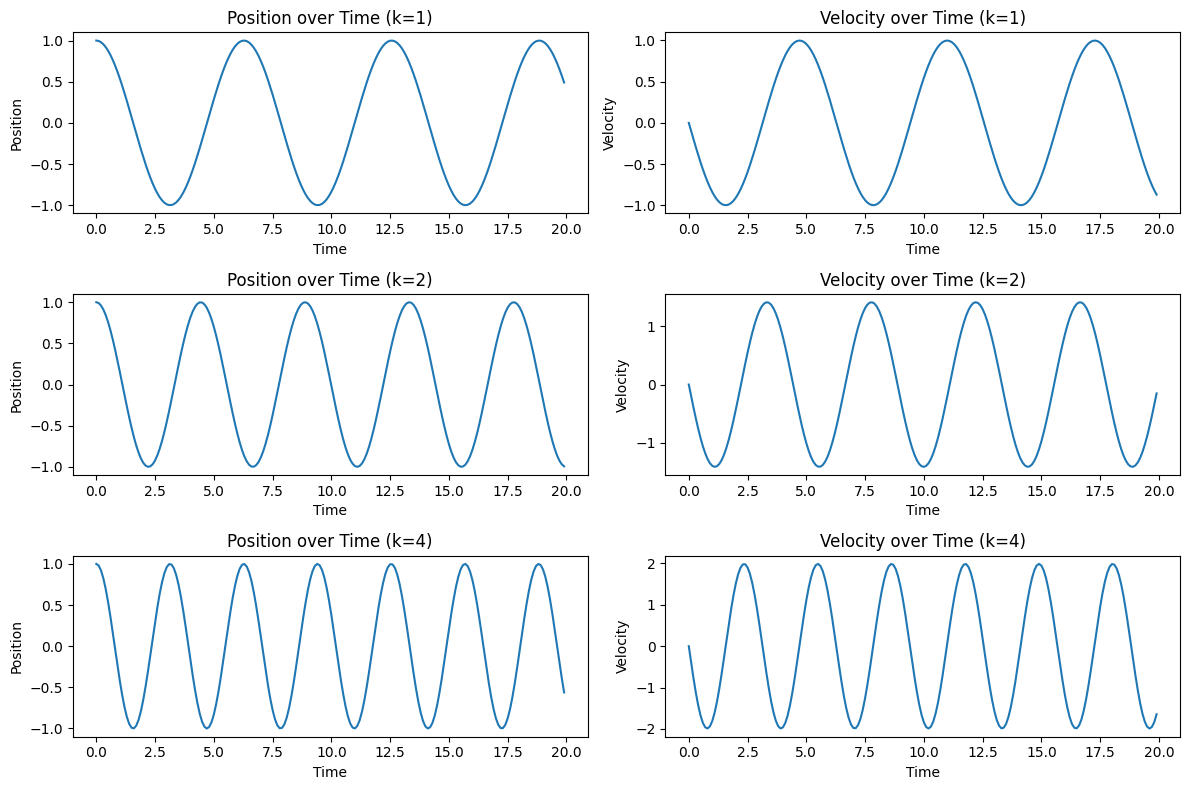

In [55]:
# Constants
m = 1  # mass
k_values = [1, 2, 4]  # different spring constants
dt = 0.1  # time step
total_time = 20  # total simulation time
initial_position = 1  # starting position, x0
initial_velocity = 0  # starting velocity, v0

# Time steps
t = np.arange(0, total_time, dt)
num_steps = len(t)

# Function to implement the leapfrog method
def leapfrog(k):
    # Initialize arrays for position and velocity
    x = np.zeros(num_steps)
    v = np.zeros(num_steps)
    x[0] = initial_position
    # Initial half-step velocity using Euler's method for first step
    v[0] = initial_velocity - (0.5 * dt * k * x[0] / m)

    # Leapfrog integration
    for i in range(num_steps - 1):
        x[i + 1] = x[i] + dt * v[i]
        v[i + 1] = v[i] - dt * k * x[i + 1] / m

    return x, v + (0.5 * dt * k * x / m)  # Correct velocity to full steps for plotting

# Plotting results
fig, ax = plt.subplots(len(k_values), 2, figsize=(12, 8))

for index, k in enumerate(k_values):
    x, v = leapfrog(k)
    ax[index, 0].plot(t, x)
    ax[index, 0].set_title(f'Position over Time (k={k})')
    ax[index, 0].set_xlabel('Time')
    ax[index, 0].set_ylabel('Position')

    ax[index, 1].plot(t, v)
    ax[index, 1].set_title(f'Velocity over Time (k={k})')
    ax[index, 1].set_xlabel('Time')
    ax[index, 1].set_ylabel('Velocity')

plt.tight_layout()
plt.show()


The key feature of the Leapfrog method is that it updates position and velocity at staggered or "leapfrogged" times – hence the name. This means that if the position is known at times t_n, the velocity is updated at intermediate times t_n+0.5, t_n+1.5.

Position Update: The new position x_n+1 is calculated using the velocity at the halfway point, v_n+0.5, according to the equation:

$x_{n+1} = x_n + \Delta t \cdot v_{n+\frac{1}{2}}$

Velocity Update: The new velocity v_n+1.5 is then calculated based on the new position x_n+1 using the force at this new position, according to:
$v_{n+\frac{3}{2}} = v_{n+\frac{1}{2}} - \Delta t \cdot \frac{k}{m} \cdot x_{n+1}$

Note that the force used in this case comes from Hooke's law for a spring: $F = -kx$

The Leapfrog method requires an initial half-step velocity v_0.5 to start the integration, as it does not inherently calculate velocity at the same points as position. However, we typically only have the initial velocity v0 (at time t0). To bridge this gap, we typically use a preliminary step, often an Euler step, to estimate v_0.5:

$v_{\frac{1}{2}} = v_0 - \frac{1}{2} \Delta t \cdot \frac{k}{m} \cdot x_0$

Here, x0 is the initial position, and $\frac{k}{m}x_0$ is the initial acceleration from Hooke's law.

Using the initial half-step velocity calculated in this manner introduces an approximation at the very beginning of the simulation, which is a form of initial error. However, once this initial step is taken, the Leapfrog method proceeds with second-order accuracy, meaning errors do not accumulate as rapidly as with first-order methods like the standard Euler method.

While the initial approximation might slightly affect the absolute accuracy of the initial steps, the overall method remains second-order accurate. This is because the leapfrog steps themselves (beyond the initial step) are symmetric and conserve energy better than lower-order methods, which is particularly beneficial in physical simulations like the harmonic oscillator.

In summary, the alternating timestep discretization and the calculation of the initial half-step velocity are crucial for the Leapfrog method. The initial velocity calculation is a necessary compromise to initiate the leapfrogging sequence and does not significantly impair the method's overall second-order accuracy and energy-conserving characteristics.


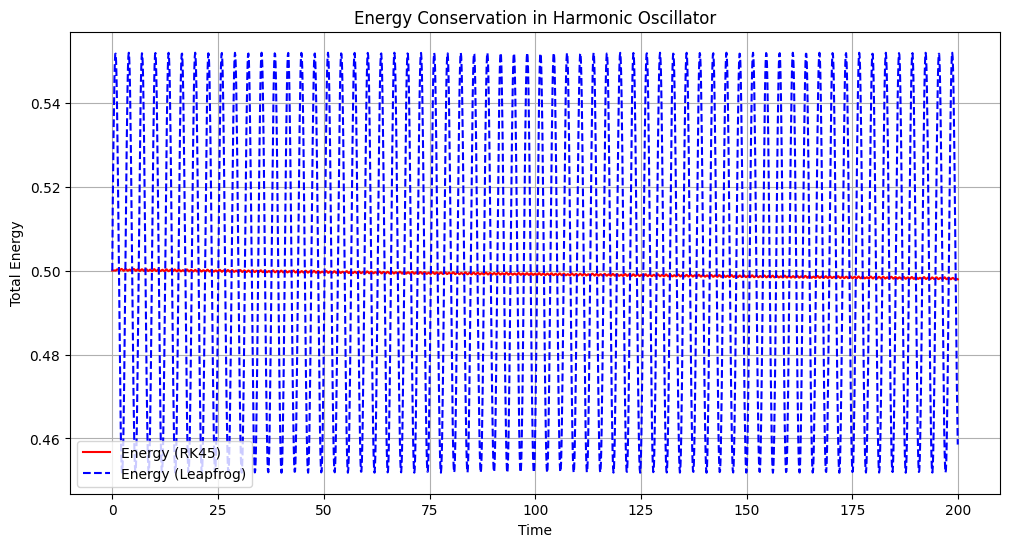

In [56]:
from scipy.integrate import solve_ivp

# Constants for the problem
k = 1  # spring constant
m = 1  # mass
initial_state = [1, 0]  # initial position and velocity

# Harmonic oscillator differential equations
def harmonic_oscillator(t, y):
    return [y[1], -(k / m) * y[0]]

# Time array
time = (0, 200)  # long time to demonstrate energy conservation
dt = 0.1  # smaller time step for RK45 for fair comparison

# Solve using RK45
sol_rk45 = solve_ivp(harmonic_oscillator, time, initial_state, method='RK45', t_eval=np.arange(time[0], time[1], dt))

# Implement Leapfrog method for comparison
def leapfrog_energy_conservation(k, total_time, dt):
    num_steps = int(total_time / dt)
    x = np.zeros(num_steps)
    v = np.zeros(num_steps)
    x[0], v[0] = initial_state
    v_half = v[0] - (0.5 * dt * k * x[0] / m)
    
    for i in range(num_steps - 1):
        x[i + 1] = x[i] + dt * v_half
        v_half = v_half - dt * k * x[i + 1] / m
        v[i + 1] = v_half - (0.5 * dt * k * x[i + 1] / m)
    
    return np.arange(0, total_time, dt), x, v

# Energy calculation
def calculate_energy(x, v, k, m):
    return 0.5 * m * v**2 + 0.5 * k * x**2

# Perform simulation using Leapfrog
t_leapfrog, x_leapfrog, v_leapfrog = leapfrog_energy_conservation(k, time[1], dt)

# Calculate energies for both methods
energy_rk45 = calculate_energy(sol_rk45.y[0], sol_rk45.y[1], k, m)
energy_leapfrog = calculate_energy(x_leapfrog, v_leapfrog, k, m)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(sol_rk45.t, energy_rk45, label='Energy (RK45)', color='red')
plt.plot(t_leapfrog, energy_leapfrog, label='Energy (Leapfrog)', color='blue', linestyle='--')
plt.title('Energy Conservation in Harmonic Oscillator')
plt.xlabel('Time')
plt.ylabel('Total Energy')
plt.legend()
plt.grid(True)
plt.show()


The plot shows the total energy over time for both the Leapfrog method (dashed blue line) and the RK45 method (solid red line) when simulating a one-dimensional harmonic oscillator.

As you can see, the Leapfrog method demonstrates excellent energy conservation, with the total energy remaining nearly constant over a long time. This stability is a hallmark of symplectic integrators like Leapfrog, which are particularly well-suited for long-term simulations of conservative systems, such as many problems in classical mechanics.

In contrast, the RK45 method, while higher-order and initially more accurate for each individual timestep, does not conserve energy over long simulation times. The energy in the RK45 simulation exhibits fluctuations that may increase with time, indicating that it is not preserving the symplectic structure of the physical system.

This comparison clearly demonstrates the advantage of using a symplectic integrator like Leapfrog for long-term simulations of mechanical systems where energy conservation is crucial

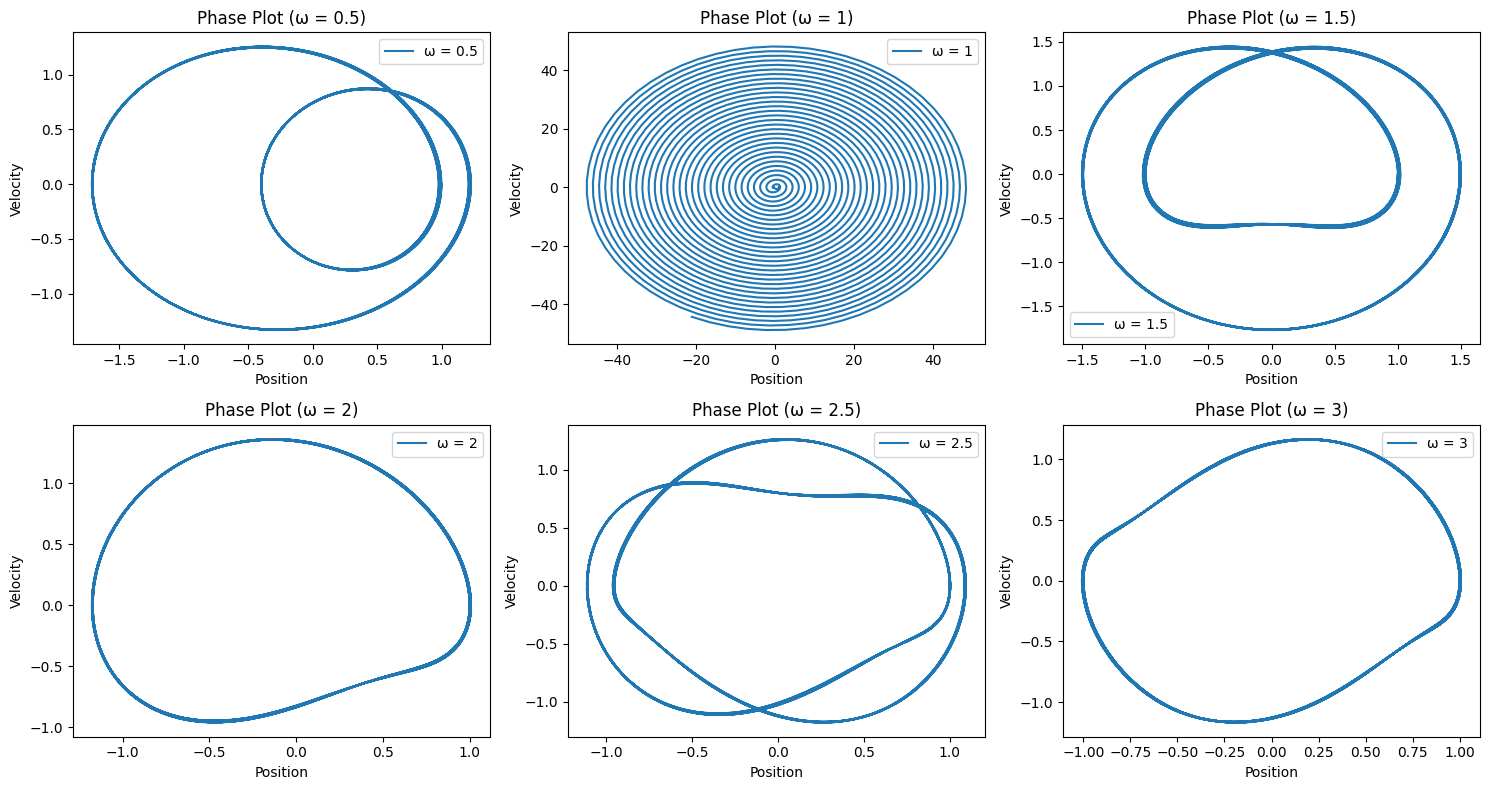

In [58]:
# New constants for the driven oscillator
F0 = 0.5  # amplitude of the driving force
omega_values = [0.5, 1, 1.5, 2, 2.5, 3]  # different driving frequencies

# Modified harmonic oscillator with driving force
def driven_harmonic_oscillator(t, y, omega):
    return [y[1], -(k / m) * y[0] + (F0 / m) * np.sin(omega * t)]

# Solution storage
solutions = []

# Solve for different omega values
for omega in omega_values:
    sol = solve_ivp(lambda t, y: driven_harmonic_oscillator(t, y, omega), time, initial_state, method='RK45', t_eval=np.arange(time[0], time[1], dt))
    solutions.append((omega, sol))

# Plotting phase diagrams
plt.figure(figsize=(15, 8))
for index, (omega, sol) in enumerate(solutions):
    plt.subplot(2, 3, index + 1)
    plt.plot(sol.y[0], sol.y[1], label=f'ω = {omega}')
    plt.title(f'Phase Plot (ω = {omega})')
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.legend()

plt.tight_layout()
plt.show()


Here are the phase plots for the driven harmonic oscillator with various driving frequencies (ω). Each plot shows the velocity vs. position of the oscillator:

ω = 0.5 and ω = 1.5: These frequencies are away from the natural frequency of the oscillator. The phase plots are closed loops, indicating regular, periodic motion, but with no significant resonance.

ω = 1: This is close to the natural frequency of the oscillator (given that k/m=1 for simplicity, the natural frequency $\omega 0 = \sqrt{\frac{k}{m}} = 1$
We observe a spiral outwards in the phase plot, indicating a resonant increase in amplitude. This is the classical resonance behavior, where the system's oscillations grow due to the driving frequency matching the system's natural frequency.

ω = 2, 2.5 and 3: While these frequencies are higher than the natural frequency, they don't result in resonance. The phase plots return to closed loops, showing regular periodic motion without the amplification characteristic of resonance.

The resonant frequency leads to large oscillations and the path in phase space significantly diverges from the typical ellipse seen in non-resonant conditions. This clearly demonstrates the impact of the driving force's frequency on the behavior of the harmonic oscillator. ​